In [ ]:
import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from dataloaders.dataset import VideoDataset
from network import R3D_model, C3D_model, R2Plus1D_model, Pac3D_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import random   

In [1]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
############################
####    Parameters      ####
############################
nEpochs = 10  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 10 # Run on test set every nTestInterval epochs
save_epoch = 10 # Store a model every save_epoch
lr = 1e-3 # Learning rate
clip_len = 256 # frames of each video

###################################
####    Options of Dataset     ####
###################################
dataset = 'CIC-IDS2018' 
modelName = 'Pac3D' 
saveName = modelName + '-' + dataset

if dataset == 'CIC-IDS2018':
    num_classes = 14
    set_seed(7)
elif dataset == 'CIC-IDS2018-v1-DoS':
    num_classes = 4
    set_seed(35)
elif dataset == 'CIC-IDS2018-v2-DoS':
    num_classes = 4
    set_seed(50)
elif dataset == 'CIC-IDS2018-v3-DoS':
    num_classes = 4
    set_seed(6)
elif dataset == 'CIC-IDS2018-v3-DDoS':
    num_classes = 3
    set_seed(35)
elif dataset == 'CIC-IDS2018-v3-Auth':
    num_classes = 2
    set_seed(9)
elif dataset == 'CIC-IDS2018-v3-Web':
    num_classes = 3
    set_seed(2)
elif dataset == 'CIC-IDS2018-v3-Other':
    num_classes = 2
    set_seed(21)
else:
    print('No Dataset')
    raise NotImplementedError

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

NameError: name 'random' is not defined

In [ ]:

##########################################
####   Set Model result saving dir    ####
##########################################
save_dir_root = os.path.join("/SSD/p76111262/")
resume_epoch = 0

if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    if len(runs) == 0:
        run_id = 0
    else:
        run_id = max([int(i.split('_')[-1]) for i in runs]) + 1
save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))


In [ ]:
######################################
####   Load model & parameters    ####
######################################
if modelName == 'C3D':
    model = C3D_model.C3D(num_classes=num_classes, pretrained=False)
    train_params = [{'params': C3D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': C3D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R2Plus1D':
    model = R2Plus1D_model.R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = [{'params': R2Plus1D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': R2Plus1D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R3D':
    model = R3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
elif modelName == 'Pac3D':
    model = Pac3D_model.Pac3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
else:
    print('We only implemented C3D and R2Plus1D models.')
    raise NotImplementedError


In [ ]:
######################################
####   Load model & parameters    ####
######################################
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(train_params, lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # the scheduler divides the lr by 10 every 5 epochs

if resume_epoch == 0:
    print("Training {} from scratch...".format(modelName))
else:
    checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                    map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
    print("Initializing weights from: {}...".format(
        os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['opt_dict'])

print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

model.to(device)
criterion.to(device)

log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
print("log dir:", log_dir)
writer = SummaryWriter(log_dir=log_dir)


Training Pac3D from scratch...
Total params: 5.66M
log dir: /SSD/p76111262/run/run_34/models/May29_22-47-55_uscc-ai-server


In [ ]:

########################
####   Load Data    ####
########################
print('Training model on {} dataset...'.format(dataset))
train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train', clip_len=clip_len), batch_size=16, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(VideoDataset(dataset=dataset, split='val', clip_len=clip_len), batch_size=16, num_workers=0)
test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=clip_len), batch_size=16, num_workers=0)

trainval_loaders = {'train': train_dataloader, 'val': val_dataloader}
trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ['train', 'val']}
test_size = len(test_dataloader.dataset)


Training model on CIC-IDS2018 dataset...


In [ ]:
train_losses = []
train_accs = []
y_pred = []
y_true = []

for epoch in range(resume_epoch, nEpochs):
    start_time = timeit.default_timer()

    # reset the running loss and corrects
    running_loss = 0.0
    running_corrects = 0.0

    # set model to train mode
    model.train()

    for inputs, labels in tqdm(trainval_loaders['train']):
        # move inputs and labels to the device the training is taking place on
        labels = labels.type(torch.LongTensor)
        inputs = Variable(inputs, requires_grad=True).to(device)
        labels = Variable(labels).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        probs = nn.Softmax(dim=1)(outputs)
        preds = torch.max(probs, 1)[1]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / trainval_sizes['train']
    epoch_acc = running_corrects.double() / trainval_sizes['train']

    writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
    writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print("[train] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
    stop_time = timeit.default_timer()
    print("Execution time: " + str(stop_time - start_time) + "\n")

    if epoch % save_epoch == (save_epoch - 1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'opt_dict': optimizer.state_dict(),
        }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
        print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

    if useTest and epoch % nTestInterval == (nTestInterval - 1):
        model.eval()
        start_time = timeit.default_timer()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects.double() / test_size
    
        writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
        writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)

        print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")

writer.close()
torch.save(model.state_dict(), "/SSD/p76111262/"+modelName+"_run"+str(run_id)+".pth")


  0%|          | 0/119 [00:00<?, ?it/s]

  4%|▍         | 5/119 [00:14<05:29,  2.89s/it]

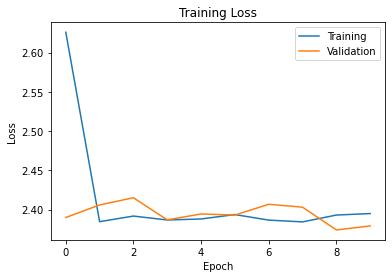

In [ ]:
import matplotlib.pyplot as plt
x = list(range(nEpochs))
plt.plot(x, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(save_dir + '/training_loss.png')
plt.show()

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    y_pred = []   #保存預測label
    y_true = []   #保存實際label
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            num_samples += 1
            num_correct += torch.sum(preds == labels.data)
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())
        acc = num_correct.double() / test_size
        print("[test] Acc: {}".format(acc))
    return y_pred, y_true
        

In [ ]:
checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar'), 
                        map_location=lambda storage, loc: storage)   
print("Initializing weights from: {}...".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar')))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_dict'])
y_pred, y_true = check_accuracy(test_dataloader, model)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Initializing weights from: /SSD/p76111262/run/run_27/models/Pac3D-CIC-IDS2018_epoch-9.pth.tar...


100%|██████████| 34/34 [00:28<00:00,  1.19it/s]

[test] Acc: 0.4030131826741996
Precision:  0.2879711073895999
Recall:  0.3821428571428572
F1:  0.30241578980196687



/home/p76111262/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/tmp/ipykernel_652581/2492310596.py:4: RuntimeWarning: invalid value encountered in true_divide
  per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)


['Botnet', 'BruteForce-FTP', 'BruteForce-SSH', 'BruteForce-Web', 'BruteForce-XSS', 'DDoS_HOIC', 'DDoS_LOIC-HTTP', 'DDoS_LOIC-UDP', 'DoS_GoldenEye', 'DoS_Hulk', 'DoS_SlowHTTPTest', 'DoS_Slowloris', 'Infiltration', 'SQL_Injection']
[0.8               nan 0.6779661  0.92682927        nan        nan
 0.16              nan        nan        nan 0.49382716 0.97297297
 0.                nan]


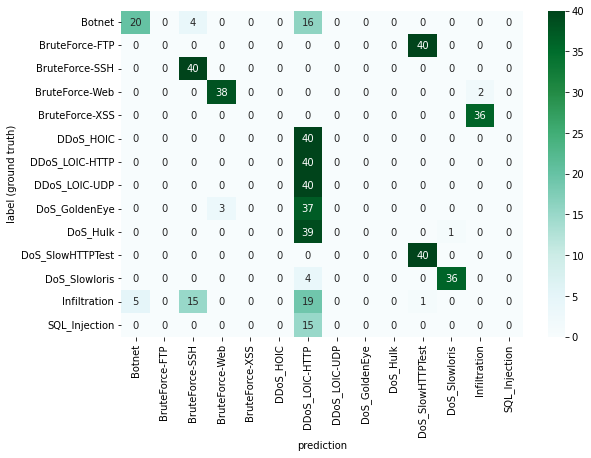

In [ ]:

# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)                               
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   

class_names = []
label_txt = os.path.join('dataloaders', dataset + ".txt")  # 這裡要改成你的label.txt路徑
with open(label_txt, 'r') as f:
    for line in f:
        class_names.append(line.strip())
        
print(class_names)
print(per_cls_acc)                                            

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)    
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig(save_dir + '/confusion_matrix.png')

In [ ]:
print(y_pred)

[0, 0, 2, 0, 6, 0, 2, 6, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 6, 6, 0, 0, 6, 0, 2, 6, 6, 6, 0, 0, 0, 6, 6, 2, 6, 6, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 